## Imports and data loading ##

In [112]:
import os
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud
import random
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

data_directory = 'C:/Users/61407/mental-health-modelling/data'
db = 'mental_health.sqlite'

In [5]:
con = sqlite3.connect(os.path.join(data_directory, db))
cur = con.cursor()

## Schema and data structure ##

In [6]:
tables = cur.execute("""SELECT name FROM sqlite_master WHERE 
            type = 'table'""").fetchall()
print(tables)

[('Answer',), ('Question',), ('Survey',)]


In [7]:
for table_name in tables:
    name = table_name[0]
    table = pd.read_sql_query(f'SELECT * FROM {name}', con)
    print(f'{name} table:')
    print(f'keys: {list(table.columns)}')
    print(f'{table.shape[0]} rows')
    print()

Answer table:
keys: ['AnswerText', 'SurveyID', 'UserID', 'QuestionID']
236898 rows

Question table:
keys: ['questiontext', 'questionid']
105 rows

Survey table:
keys: ['SurveyID', 'Description']
5 rows



## Investigation of questions ##

In [123]:
questions = pd.read_sql_query(f'SELECT * FROM Question', con)
questions_text = ''
for idx, q in questions.iterrows():
    questions_text = questions_text+' '+q.questiontext
questions_text = questions_text.lower() #always make sure to lower case all words since not all packages would do this in the back end

- What are the most common words across the questions? (with obvious words such as 'mental', 'health', and 'issue' removed)

C:\Users\61407\AppData\Local\Temp\ipykernel_33268\4228164008.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm);


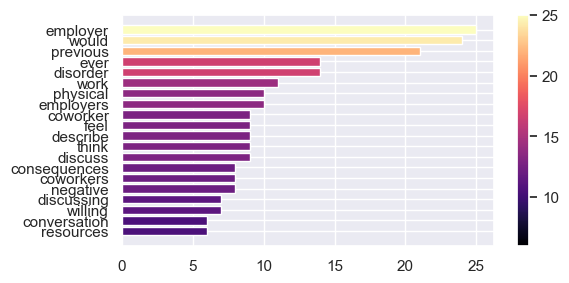

In [145]:
# Tokenize the text
tokens = word_tokenize(questions_text)

# Remove punctuation and convert to lowercase
tokens = [word for word in tokens if word.isalpha()]

# Remove stop words
stop_words = set(list(set(stopwords.words('english'))) + ['mental','health','issue'])
filtered_tokens = [word for word in tokens if word not in stop_words]

# Calculate word frequencies
word_freq = FreqDist(filtered_tokens)

## Create dataframe of all word counts ##
word_freq_df = pd.DataFrame(word_freq.values(),
                           index=word_freq.keys(),
                           columns=['count'])

## Select data of interest ##
plot_df = word_freq_df.sort_values('count',ascending=False)[:20].sort_values('count')
vals = plot_df.values.reshape(-1)

## Define colormap and colorbar ##
colormap = plt.get_cmap('magma')
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(min(vals), max(vals))) #vals = your values

## Plot bars and colorbars ##
plt.figure(figsize=(6,3))
plt.barh(plot_df.index, vals, color=[colormap(i / max(vals)) for i in vals])
plt.colorbar(sm);

- See if a word cloud makes things any clearer

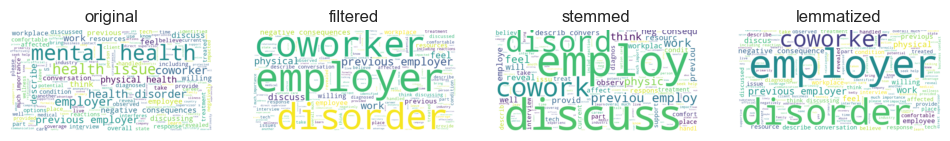

In [152]:
# Stemming (using the Porter Stemmer)
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

# Lemmatization (using the WordNet Lemmatizer)
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

# Create Word Clouds for the original and filtered text
original = WordCloud(width=800, height=400, background_color="white").generate(" ".join(tokens))
filtered = WordCloud(width=800, height=400, background_color="white").generate(" ".join(filtered_tokens))
stemmed = WordCloud(width=800, height=400, background_color="white").generate(" ".join(stemmed_tokens))
lemmatized = WordCloud(width=800, height=400, background_color="white").generate(" ".join(lemmatized_tokens))

# Plot the Word Clouds
fig, ax = plt.subplots(nrows=1, ncols=4,
                       figsize=(12, 3))
for col, (cloud, title) in enumerate(zip([original, filtered, stemmed, lemmatized],
                                         ['original', 'filtered', 'stemmed', 'lemmatized']
                                        )
                                    ):
    ax[col].imshow(cloud, interpolation = 'bilinear')
    ax[col].axis('off')
    ax[col].set_title(title)
plt.show()

1. **Lots of questions with the word "disorder" - they may be good target variables (i.e. diagnosis-prediction)**
2. **Lots of questions with the word "employer" and "coworker" as well - they may be interesting features (i.e. how does employer/coworker treatment or relationship affect mental health?)
- Let's see what these questions are exactly

In [160]:
disorder_df = pd.read_sql_query("""SELECT questionid id, questiontext txt
                                   FROM Question
                                   WHERE (questiontext LIKE '%disord%')
                                      OR (questiontext LIKE '%employer%')
                                      OR (questiontext LIKE '%cowork%')                                      
                                """, 
                                con)
for index, rows in disorder_df.iterrows():
    print(f'{rows.id}. {rows.txt}')

7. Have you ever sought treatment for a mental health disorder from a mental health professional?
9. Is your employer primarily a tech company/organization?
10. Does your employer provide mental health benefits as part of healthcare coverage?
11. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12. Would you bring up a mental health issue with a potential employer in an interview?
14. Do you know the options for mental health care available under your employer-provided health coverage?
15. Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
16. Does your employer offer resources to learn more about mental health disorders and options for seeking help?
18. Would you feel comfortable discussing a mental health issue with your coworkers?
20. Do you have medical coverage (private insurance or state-provided) that in

**Manually select some possible questions that could provide a target for classification (i.e. mental health outcome related)**

In [161]:
possible_target_questions = (7,33,34)
target_questions_df = pd.read_sql_query(f'SELECT * FROM Question WHERE questionid in {possible_target_questions}', con)
for index, rows in target_questions_df.iterrows():
    print(rows.questiontext)

Have you ever sought treatment for a mental health disorder from a mental health professional?
Do you currently have a mental health disorder?
Have you ever been diagnosed with a mental health disorder?


- How many answers do we have to each of these questions?

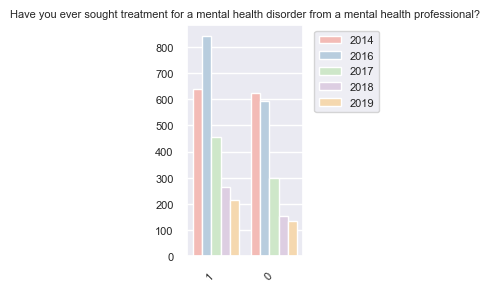

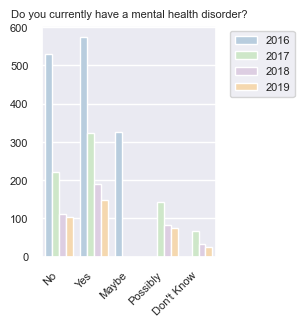

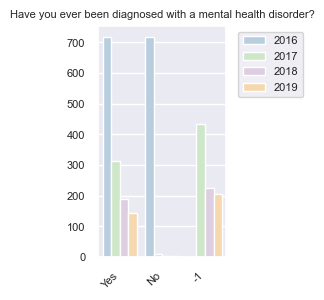

In [162]:
survey_years = pd.read_sql_query('SELECT DISTINCT(SurveyID) FROM Survey', con).values
cmap = plt.get_cmap('Pastel1')
colors_by_year = {int(survey_years[i]):cmap(x) for i, (x) in enumerate(list(range(len(survey_years))))}
sns.set()
for qid in possible_target_questions:
    question = pd.read_sql_query(f'SELECT * FROM Question WHERE QuestionID = {qid}', con)['questiontext'].values
    answer_agg = pd.read_sql_query(f"""SELECT 
                                           AnswerText, SurveyID,
                                       COUNT(*) 
                                           AS 'num'
                                       FROM
                                           Answer
                                       WHERE 
                                           QuestionID = {qid}
                                       GROUP BY
                                           AnswerText, SurveyID
                                   """,
                               con)
    answer = pd.read_sql_query(f"""SELECT *
                                   FROM
                                       Answer
                                   WHERE 
                                       QuestionID = {qid}
                                   """,
                               con)
    fig, ax = plt.subplots(nrows=1, ncols=1,
                           figsize=(0.15*answer_agg.shape[0],3))
    sns.countplot(data=answer, x='AnswerText',
                  stat='count',
                  hue='SurveyID', palette=colors_by_year, saturation=0.8,
                  ax=ax,
               )
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(question[0], fontsize=8)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

- Questions that have a relatively robust availability of data:
    1. Have you ever sought treatment for a mental health disorder from a mental health professional?
    2. Do you currently have a mental health disorder?

## Join relevant tables for question 1. ##

In [11]:
q_to_select = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'

## Get all rows from all survey years ##
question1 = pd.read_sql_query(f"""SELECT 
                         Answer.AnswerText, Answer.SurveyID
                     FROM
                         Answer
                     LEFT JOIN
                         Question
                     ON
                         Answer.QuestionID = Question.questionid
                     WHERE
                         Question.questiontext = '{q_to_select}';
                    """, 
                  con)